In [42]:
import os
import pandas as pd
import numpy as np
np.random.seed(12345)
import seaborn as sns
import matplotlib.pyplot as plt


def fasta_reader(file):
    '''Converts .fasta to a pandas dataframe with accession as index
    and sequence in a column 'sequence'
    '''
    fasta_df = pd.read_csv(file, sep='>', lineterminator='>', header=None)
    fasta_df[['Accession', 'Sequence']] = fasta_df[0].str.split('\n', 1, \
                                        expand=True)
    fasta_df['Accession'] = fasta_df['Accession']
    fasta_df['Sequence'] = fasta_df['Sequence'].replace('\n', '', regex=True).\
                            astype(str).str.upper().replace('U', 'T')
    total_seq = fasta_df.shape[0]
    fasta_df.drop(0, axis=1, inplace=True)
    fasta_df = fasta_df[fasta_df.Sequence != '']
    fasta_df = fasta_df[fasta_df.Sequence != 'NONE']
    final_df = fasta_df.dropna()
    remained_seq = final_df.shape[0]
    if total_seq != remained_seq:
        print("{} sequences were removed due to inconsistencies in"
                      "provided file.".format(total_seq-remained_seq))
    return final_df

root_dir  = os.path.abspath(os.path.join(os.getcwd(), "../.."))


In [6]:
#This step takes some time!

#path to the clusters folder. 
clusters_10 = []
clusters_20 = []
clusters_30 = []
clusters_40 = []
clusters_50 = []
clusters_60 = []
clusters_70 = []
clusters_80 = []
clusters_90 = []


all_clusters = [clusters_10, clusters_20, clusters_30, clusters_40, clusters_50, clusters_60, clusters_70, clusters_80, clusters_90]

for i, v in enumerate(list(range(10, 100, 10))):
    path = os.getcwd() + '/' + str(v) + '/'


    #remove usearch and pET fasta from cluster directory before running this

    for file in os.listdir(path):
        try:
            all_clusters[i].append(fasta_reader(os.path.abspath(os.path.join(str(v) + '/', file))))
        except Exception:
            pass



In [7]:
for i, v in enumerate(all_clusters):
    print('ID = %d has %d clusters.' %(list(range(10, 100, 10))[i], len(v)))

ID = 10 has 4368 clusters.
ID = 20 has 4781 clusters.
ID = 30 has 4941 clusters.
ID = 40 has 5050 clusters.
ID = 50 has 5277 clusters.
ID = 60 has 5758 clusters.
ID = 70 has 6124 clusters.
ID = 80 has 6411 clusters.
ID = 90 has 6616 clusters.


In [8]:
import copy 
all_clusters_copy = copy.deepcopy(all_clusters)

In [9]:
for i, v in enumerate(all_clusters):
    #remove character ----- from alignment

    for index, c in enumerate(v):
        c['Prot'] = c['Sequence'].str.replace('-','')
        c['Cluster'] = index

concat_dfs = [pd.concat(i) for i in all_clusters]
pET = pd.read_pickle(root_dir+'/results/pET_complete.pkl.gz')
merged_dfs = [i.merge(pET, on='Accession') for i in concat_dfs] #to get solubility

count_df = []
for i, v in enumerate(merged_dfs):
    c = []
    sol = []
    clusters_unique = v.Cluster.unique()
    for j, w in enumerate(clusters_unique):
        if len(v.loc[v.Cluster == w].Solubility.values) > 1: #get rid of single ones
            c.append(j)
            sol.append(v.loc[v.Cluster == w].Solubility.values)
    df = pd.DataFrame({'Cluster':c, 'Solubility':sol})
    df['Percentage_of_1'] = df['Solubility'].apply(lambda x:max([100 * (x == 1).sum()/len(x),\
                                                                 100 *(1 - (x == 1).sum()/len(x))]))
    count_df.append(df)

new_df = pd.DataFrame({'10':count_df[0]['Percentage_of_1'], \
                       '20':count_df[1]['Percentage_of_1'],\
                        '30':count_df[2]['Percentage_of_1'], \
                      '40':count_df[3]['Percentage_of_1'], \
                     '50':count_df[4]['Percentage_of_1'], \
                     '60':count_df[5]['Percentage_of_1'], \
                     '70':count_df[6]['Percentage_of_1'], \
                     '80':count_df[7]['Percentage_of_1'], \
                     '90':count_df[8]['Percentage_of_1'], })

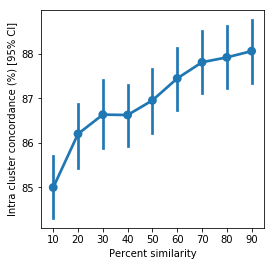

In [39]:
plt.figure(figsize=(4, 4))
nnn = new_df.melt()
ax = sns.pointplot(y='value', x='variable', data=nnn)
ax.set_xlabel('Percent similarity')
ax.set_ylabel('Intra cluster concordance (%) [95% CI]')
plt.savefig(root_dir + '/figs/concordance.pdf')

In [28]:
ids_cluster = list(range(10, 100, 10))
num_clusters = []
for i, v in enumerate(all_clusters):
    num_clusters.append(len(v))

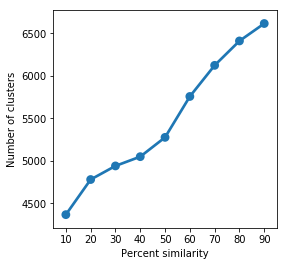

In [40]:
plt.figure(figsize=(4, 4))
ax = sns.pointplot(ids_cluster, num_clusters)
ax.set_xlabel('Percent similarity')
ax.set_ylabel('Number of clusters')
plt.savefig(root_dir + '/figs/number_of_clusters_with_similarity.pdf')

### Number of sequences in each cluster 

In [48]:
for i, v in enumerate(count_df):
    v['Number of Sequences'] = v['Solubility'].apply(len)

In [50]:
number_df = pd.DataFrame({'10':count_df[0]['Number of Sequences'], \
                       '20':count_df[1]['Number of Sequences'],\
                        '30':count_df[2]['Number of Sequences'], \
                      '40':count_df[3]['Number of Sequences'], \
                     '50':count_df[4]['Number of Sequences'], \
                     '60':count_df[5]['Number of Sequences'], \
                     '70':count_df[6]['Number of Sequences'], \
                     '80':count_df[7]['Number of Sequences'], \
                     '90':count_df[8]['Number of Sequences'], })

Text(0, 0.5, 'Number of sequences per cluster')

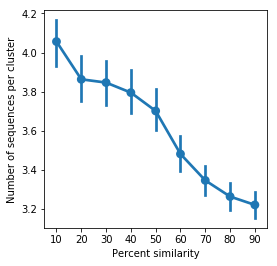

In [58]:
plt.figure(figsize=(4,4))
aaa = number_df.melt()
ax = sns.pointplot(y='value', x='variable', data=aaa)
ax.set_xlabel('Percent similarity')
ax.set_ylabel('Number of sequences per cluster')
